In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

np.random.seed(42)

# Data Generation

### The Nonlinear Circuit

<center><img src="../assets/circuit.png" width="300"/></center>

The currents and the voltages across the RLC components are related as the foloowing:

$$
i_1 + i_3 = i_2
$$

$$
i_3 = C(V_3)\frac{dV3}{dt}
$$

$$
V_2 - V_3 = R(i_3)i_3
$$

$$
-V2 = L_2(i_2)\frac{di_2}{dt}
$$

$$
V_2 - V_1 = L_1(i_1)\frac{di_1}{dt}
$$

### The Nonlinear functions for $R(i), C(V), L_1(i), L_2(i)$ and $V_1(t)$
These are **five** of the functions that we'll try to reconstruct using CGC

In [2]:
def R(i):
    R0, R1 = 1, 2
    i0 = 3
    R = R0 * (1 + R1 * (i / i0) ** 2) / (1 + R0 * (i / i0) **2)
    return R

def C(V):
    C0, C1 = 1, 0.5
    V0 = 1
    C = C0 * (1 + C1 * (V / V0) **2) / (1 + C0 * (V / V0) ** 2)
    return C

def L1(i):
    L0 = 1
    L1_ = 0.5
    i0 = 3
    L1 = L0 * (1 + L1_ * (i / i0) ** 2) / (1 + L0 * (i / i0) ** 2)
    return L1

def L2(i):
    L0 = 1
    L1_ = 0.5
    i0 = 1
    L2 = L0 * (1 + L1_ * (i / i0) ** 4) / (1 + L0 * (i / i0) ** 4)
    return L2

def V1(t):
    V0 = 1
    period = np.pi / 2
    V1 = V0 * np.sin(period * t)
    return V1

### Integerating the ODEs above to solve for $V_3(t), i_1(t)$ and $i_2(t)$ for $t \in [0, 10)$ with $\Delta t=0.1$
From the solutions of $V_3(t), i_1(t)$ and $i_2(t)$, we can calculate the values of $i_3(t)$ and $V_2(t)$. These another **five** function complete the set of functions that we'll attempt to recover using CGC. 

In [3]:
N = 100
tmax = 10
i = np.linspace(-5, 5, num=N)
V = np.linspace(-5, 5, num=N)
t = np.linspace(0, tmax, num=N)

def circuit_ode(y, t):
    dydt = [0, 0, 0]
    dydt[0] = (y[2] - y[1])/C(y[0])
    dydt[1] = (y[0] + R(y[2] - y[1]) * (y[2] - y[1]) - V1(t)) / L1(y[1])
    dydt[2] = -(y[0] + R(y[2] - y[1]) * (y[2] - y[1])) / L2(y[2])
    return dydt

y = odeint(circuit_ode, y0=[0, 0, 0], t=t)
V3 = y[:, 0]
i1 = y[:, 1]
i2 = y[:, 2]
i3 = i2 - i1
V2 = V3 + R(i3) * i3

### The Partial Observations Mask $M$

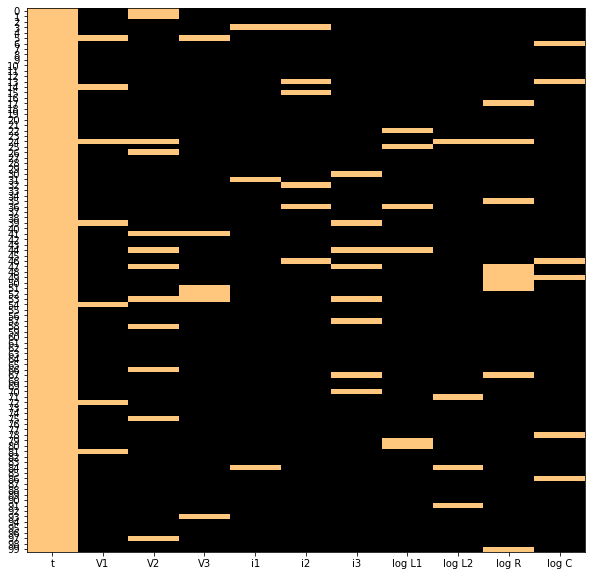

In [4]:
observables_order = ["t", "V1", "V2", "V3", "i1", "i2", "i3", "log L1", "log L2", "log R", "log C"]
M = np.full(shape=(100, 11), fill_value=True)
M[:, 1:] = np.random.choice([False, True], size=(100, 10), p=[0.93, 0.07])

fig, axis = plt.subplots(1, 1, figsize=(10, 10))

axis.set_xticks(np.arange(11), labels=observables_order)
axis.set_yticks(np.arange(100), labels=np.arange(100))
axis.imshow(M, aspect="auto", cmap='copper')

### Partial Observation Matrix $X$

In [5]:
X_true = np.zeros((100, 11))
X_true[:, 0] = t
X_true[:, 1] = V1(t)
X_true[:, 2] = V2
X_true[:, 3] = V3
X_true[:, 4] = i1
X_true[:, 5] = i2
X_true[:, 6] = i3
X_true[:, 7] = np.log(L1(i1))
X_true[:, 8] = np.log(L2(i2))
X_true[:, 9] = np.log(R(i3))
X_true[:, 10] = np.log(C(V3))

X = np.zeros_like(X_true)
X[M] = X_true[M]

### Visualizing the True Functions With the Partial Observations

(0.0, 1.0, 0.0, 1.0)

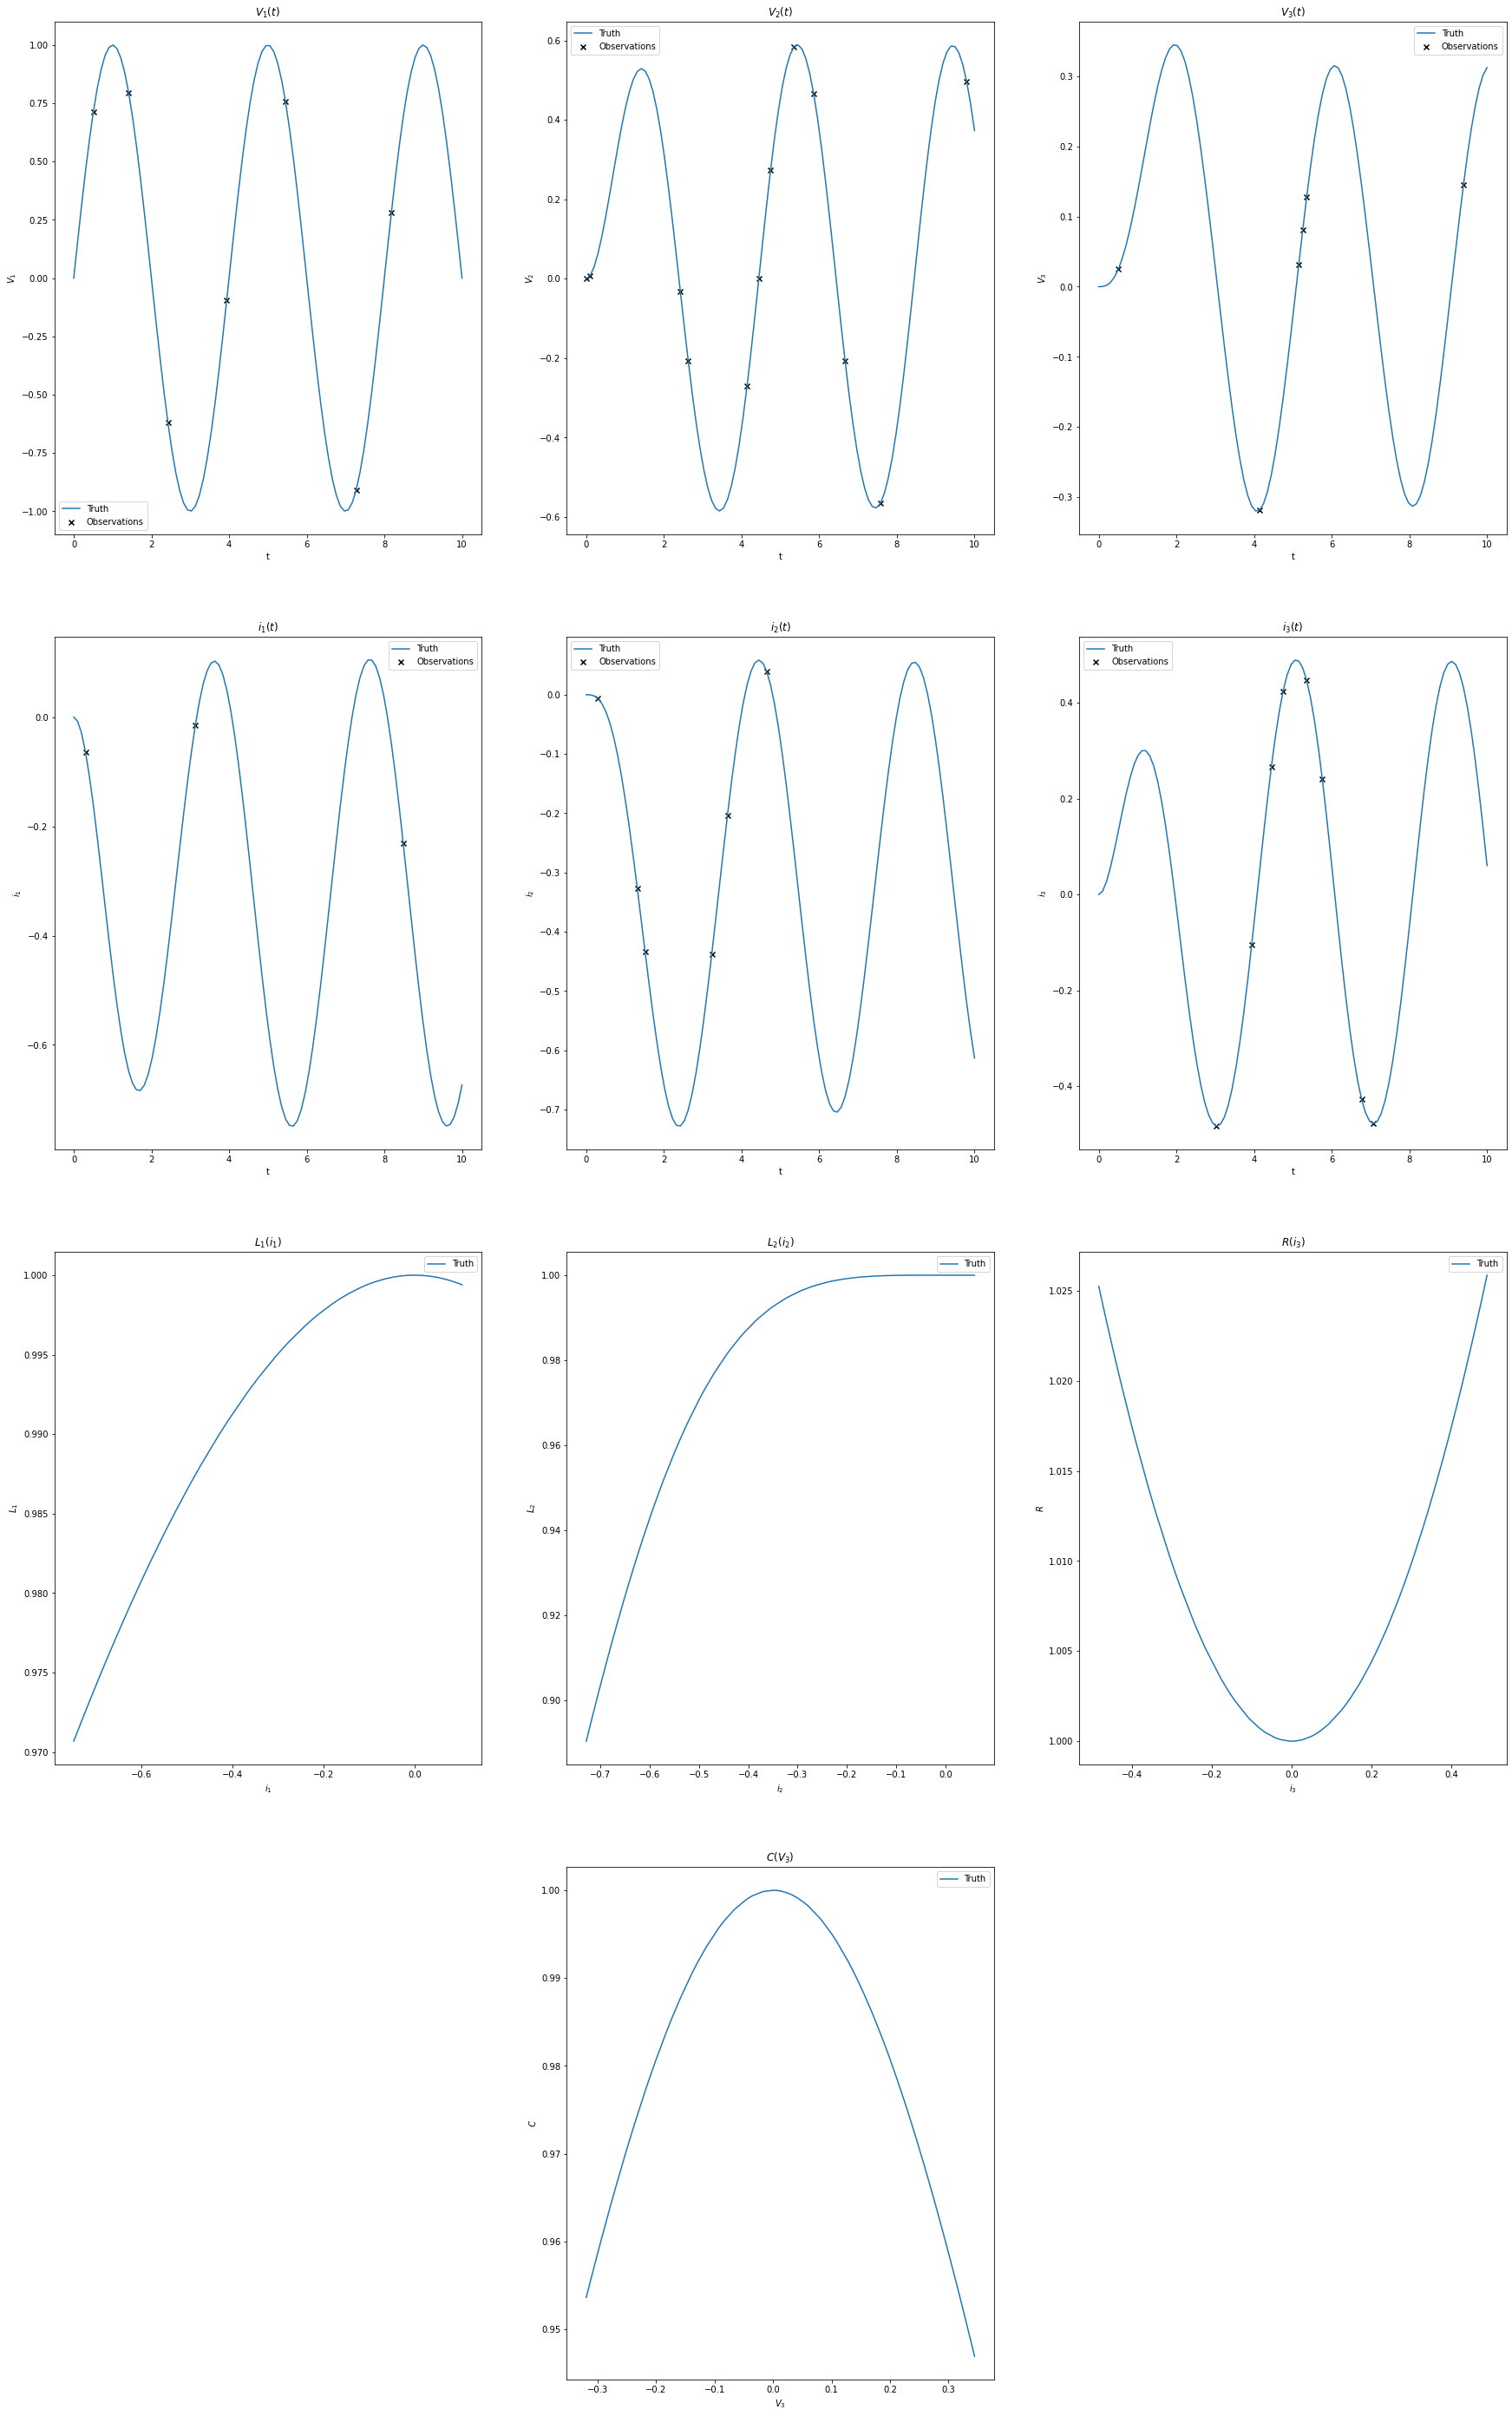

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(30, 50))

axes[0, 0].plot(t, V1(t), label="Truth")
axes[0, 0].set_title("$V_1(t)$")
axes[0, 0].set_xlabel("t")
axes[0, 0].set_ylabel("$V_1$")
axes[0, 0].scatter(t[M[:, 1]], V1(t)[M[:, 1]], marker='x', c='black', label="Observations")
axes[0, 0].legend()

axes[0, 1].plot(t, V2, label="Truth")
axes[0, 1].set_title("$V_2(t)$")
axes[0, 1].set_xlabel("t")
axes[0, 1].set_ylabel("$V_2$")
axes[0, 1].scatter(t[M[:, 2]], V2[M[:, 2]], marker='x', c='black', label="Observations")
axes[0, 1].legend()

axes[0, 2].plot(t, V3, label="Truth")
axes[0, 2].set_title("$V_3(t)$")
axes[0, 2].set_xlabel("t")
axes[0, 2].set_ylabel("$V_3$")
axes[0, 2].scatter(t[M[:, 3]], V3[M[:, 3]], marker='x', c='black', label="Observations")
axes[0, 2].legend()

axes[1, 0].plot(t, i1, label="Truth")
axes[1, 0].set_title("$i_1(t)$")
axes[1, 0].set_xlabel("t")
axes[1, 0].set_ylabel("$i_1$")
axes[1, 0].scatter(t[M[:, 4]], i1[M[:, 4]], marker='x', c='black', label="Observations")
axes[1, 0].legend()

axes[1, 1].plot(t, i2, label="Truth")
axes[1, 1].set_title("$i_2(t)$")
axes[1, 1].set_xlabel("t")
axes[1, 1].set_ylabel("$i_2$")
axes[1, 1].scatter(t[M[:, 5]], i2[M[:, 5]], marker='x', c='black', label="Observations")
axes[1, 1].legend()

axes[1, 2].plot(t, i3, label="Truth")
axes[1, 2].set_title("$i_3(t)$")
axes[1, 2].set_xlabel("t")
axes[1, 2].set_ylabel("$i_3$")
axes[1, 2].scatter(t[M[:, 6]], i3[M[:, 6]], marker='x', c='black', label="Observations")
axes[1, 2].legend()

a = np.argsort(i1)
axes[2, 0].plot(i1[a], L1(i1[a]), label="Truth")
axes[2, 0].set_title("$L_1(i_1)$")
axes[2, 0].set_xlabel("$i_1$")
axes[2, 0].set_ylabel("$L_1$")
axes[2, 0].legend()

a = np.argsort(i2)
axes[2, 1].plot(i2[a], L2(i2[a]), label="Truth")
axes[2, 1].set_title("$L_2(i_2)$")
axes[2, 1].set_xlabel("$i_2$")
axes[2, 1].set_ylabel("$L_2$")
axes[2, 1].legend()

a = np.argsort(i3)
axes[2, 2].plot(i3[a], R(i3[a]), label="Truth")
axes[2, 2].set_title("$R(i_3)$")
axes[2, 2].set_xlabel("$i_3$")
axes[2, 2].set_ylabel("$R$")
axes[2, 2].legend()

a = np.argsort(V3)
axes[3, 1].plot(V3[a], C(V3[a]), label="Truth")
axes[3, 1].set_title("$C(V_3)$")
axes[3, 1].set_xlabel("$V_3$")
axes[3, 1].set_ylabel("$C$")
axes[3, 1].legend()

axes[3, 0].axis('off')
axes[3, 2].axis('off')

Notice that no observations are shown on the plots for $L1(i_1), L_2(i_2), R(i_3)$ and $C(V_3)$, because the pratial observations we have for these values are not paired with $i_1, i_2, i_3$ and $V_3$, rather they are paired with time $t$. We can visualize the observations against $t$.

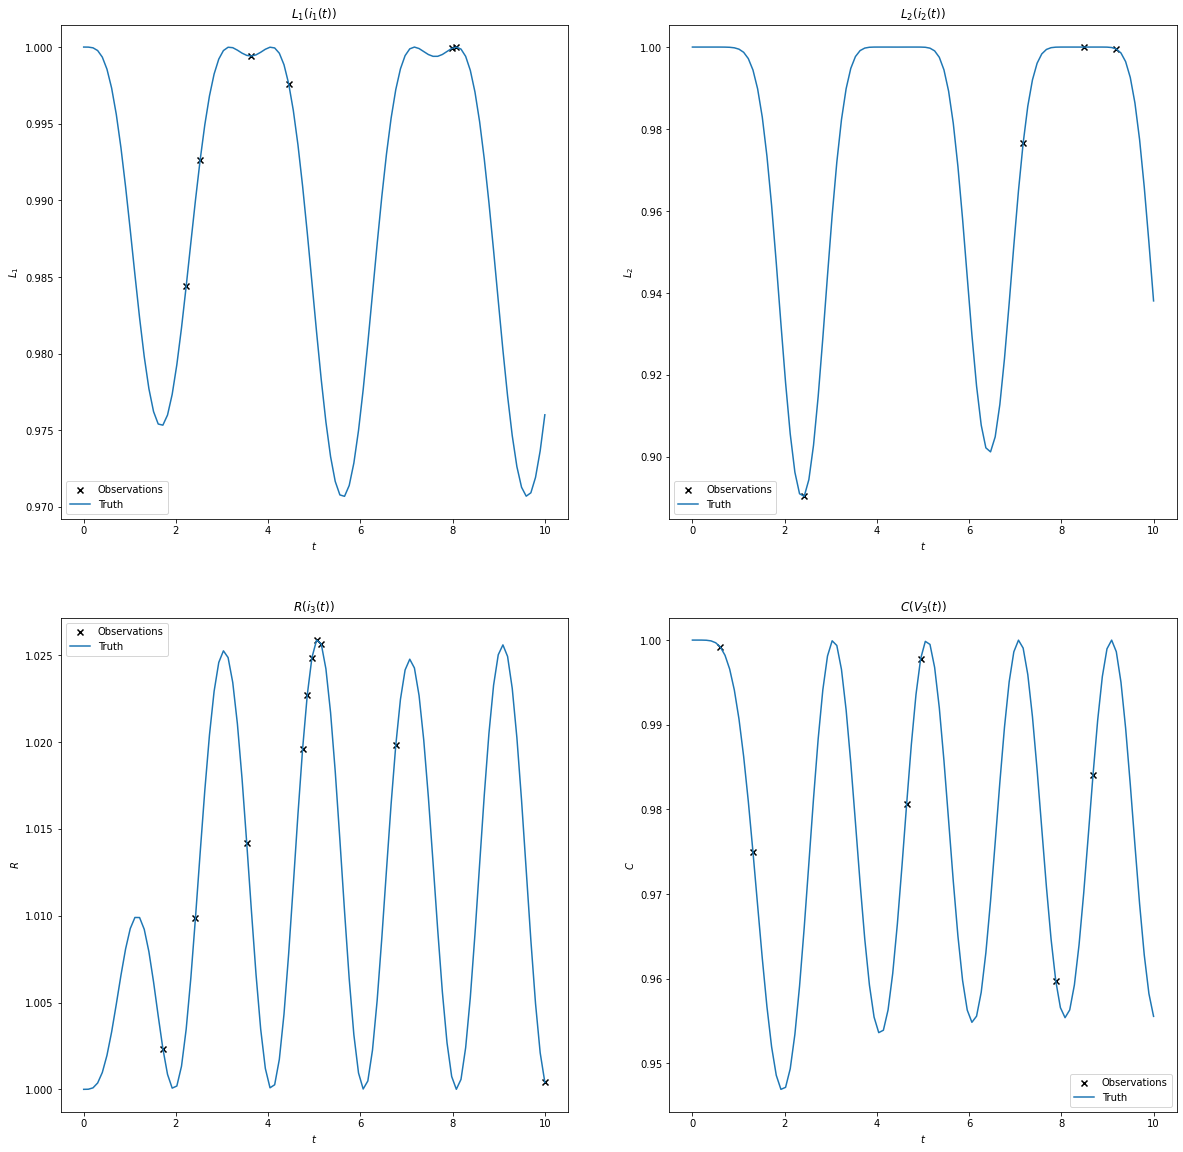

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

observed_L1_mask = M[:, 7]
axes[0, 0].scatter(t[observed_L1_mask], L1(i1)[observed_L1_mask], label="Observations", marker='x', c='black')
axes[0, 0].plot(t, L1(i1), label="Truth")
axes[0, 0].set_xlabel("$t$")
axes[0, 0].set_ylabel("$L_1$")
axes[0, 0].set_title("$L_1(i_1(t))$")
axes[0, 0].legend()

observed_L2_mask = M[:, 8]
axes[0, 1].scatter(t[observed_L2_mask], L2(i2)[observed_L2_mask], label="Observations", marker='x', c='black')
axes[0, 1].plot(t, L2(i2), label="Truth")
axes[0, 1].set_xlabel("$t$")
axes[0, 1].set_ylabel("$L_2$")
axes[0, 1].set_title("$L_2(i_2(t))$")
axes[0, 1].legend()

observed_R_mask = M[:, 9]
axes[1, 0].scatter(t[observed_R_mask], R(i3)[observed_R_mask], label="Observations", marker='x', c='black')
axes[1, 0].plot(t, R(i3), label="Truth")
axes[1, 0].set_xlabel("$t$")
axes[1, 0].set_ylabel("$R$")
axes[1, 0].set_title("$R(i_3(t))$")
axes[1, 0].legend()

observed_C_mask = M[:, 10]
axes[1, 1].scatter(t[observed_C_mask], C(V3)[observed_C_mask], label="Observations", marker='x', c='black')
axes[1, 1].plot(t, C(V3), label="Truth")
axes[1, 1].set_xlabel("$t$")
axes[1, 1].set_ylabel("$C$")
axes[1, 1].set_title("$C(V_3(t))$")
axes[1, 1].legend()

# Graph Definition

<center><img src="../assets/graph.png" width="500"></center>

In [8]:
from cgc.graph import ComputationalGraph, derivative
from jax import numpy as jnp

graph = ComputationalGraph(observables_order=observables_order)

graph.add_observable("t")
graph.add_unknown_fn("t", "V1", alpha=0.001)
graph.add_unknown_fn("t", "V2", alpha=0.001)
graph.add_unknown_fn("t", "V3", alpha=0.001)
graph.add_unknown_fn("t", "i1", alpha=0.001)
graph.add_unknown_fn("t", "i2", alpha=0.001)
graph.add_unknown_fn("t", "i3", alpha=0.001)
graph.add_unknown_fn("i1", "log L1", alpha=0.001)
graph.add_unknown_fn("i2", "log L2", alpha=0.001)
graph.add_unknown_fn("i3", "log R", alpha=0.001)
graph.add_unknown_fn("V3", "log C", alpha=0.001)

graph.add_known_fn("i1", "i1'", derivative)
graph.add_known_fn("i2", "i2'", derivative)
graph.add_known_fn("V3", "V3'", derivative)
graph.add_known_fn("log L1", "L1", jnp.exp)
graph.add_known_fn("log L2", "L2", jnp.exp)
graph.add_known_fn("log R", "R", jnp.exp)
graph.add_known_fn("log C", "C", jnp.exp)

graph.add_aggregator(["i1", "i2", "i3"], "(i1, i2, i3)")
def current_constraint(i1_i2_i3):
    i1, i2, i3 = i1_i2_i3
    return i1 + i3 - i2
graph.add_constraint("(i1, i2, i3)", "W1", current_constraint)

graph.add_aggregator(["i3", "C", "V3'"], "(i3, C, V3')")
def capacitor_constraint(i3_C_V3_):
    i3, C, V3_ = i3_C_V3_
    return i3 - C * V3_
graph.add_constraint("(i3, C, V3')", "W2", capacitor_constraint)

graph.add_aggregator(["V2", "V3", "R", "i3"], "(V2, V3, R, i3)")
def resistor_constarint(V2_V3_R_i3):
    V2, V3, R, i3 = V2_V3_R_i3
    return V2 - V3 - R * i3
graph.add_constraint("(V2, V3, R, i3)", "W3", resistor_constarint)

graph.add_aggregator(["V2", "L2", "i2'"], "(V2, L2, i2')")
def coil_2_constraint(V2_L2_i2_):
    V2, L2, i2_prime = V2_L2_i2_
    return -V2 - L2 * i2_prime
graph.add_constraint("(V2, L2, i2')", "W4", coil_2_constraint)

graph.add_aggregator(["V2", "V1", "L1", "i1'"], "(V2, V1, L1, i1')")
def coil_1_constraint(V2_V1_L1_i1_):
    V2, V1, L1, i1_prime = V2_V1_L1_i1_
    return V2 - V1 - L1 * i1_prime
graph.add_constraint("(V2, V1, L1, i1')", "W5", coil_1_constraint)

### Completing the Graph

In [9]:
graph.set_loss_multipliers(unknown_functions_loss_multiplier=20000, data_compliance_loss_multiplier=15000)

Z = graph.complete(X, M)

Loss: 66.9454:   4%|▍         | 19785/500000 [01:45<42:40, 187.55it/s]     

Stopped after 1000 steps with no improvment in Loss


### Visualizing Predictions against Truth

/Users/mostafa/opt/miniconda3/envs/cgc-env/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3293: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


(0.0, 1.0, 0.0, 1.0)

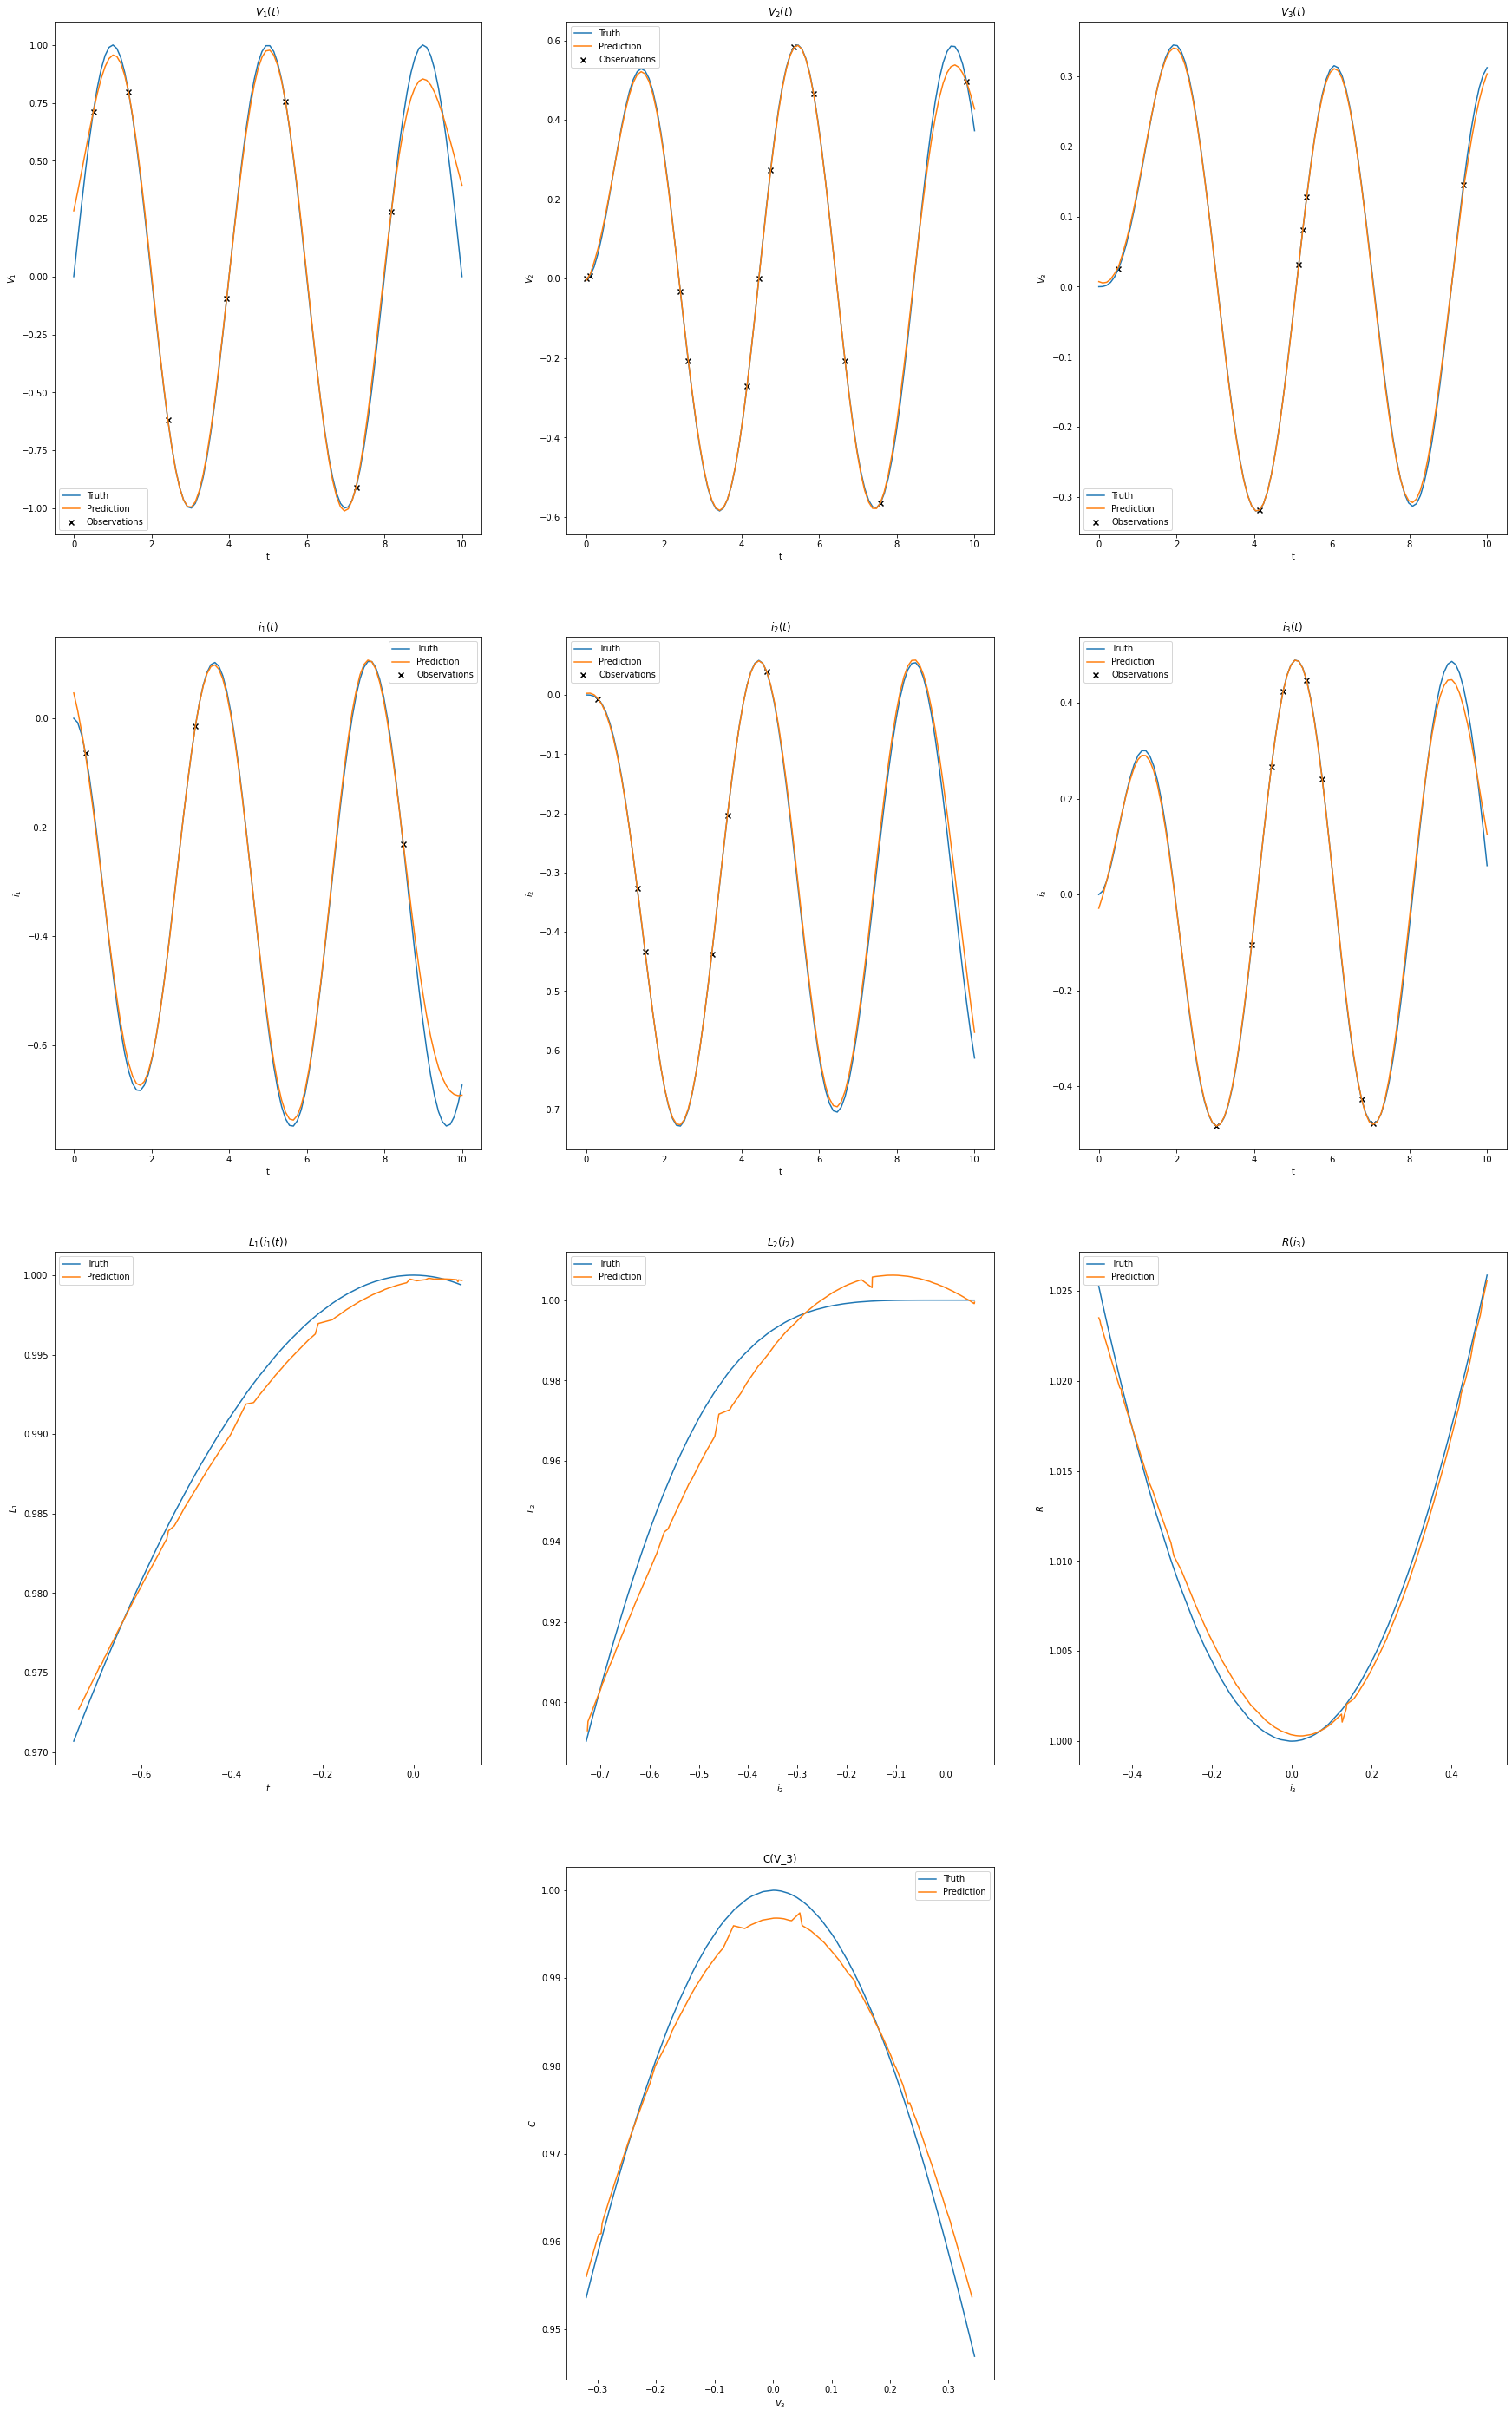

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(30, 50))

axes[0, 0].plot(t, V1(t), label="Truth")
axes[0, 0].plot(t, Z[:, 1], label="Prediction")
axes[0, 0].set_title("$V_1(t)$")
axes[0, 0].set_xlabel("t")
axes[0, 0].set_ylabel("$V_1$")
axes[0, 0].scatter(t[M[:, 1]], V1(t)[M[:, 1]], marker='x', c='black', label="Observations")
axes[0, 0].legend()

axes[0, 1].plot(t, V2, label="Truth")
axes[0, 1].plot(t, Z[:, 2], label="Prediction")
axes[0, 1].set_title("$V_2(t)$")
axes[0, 1].set_xlabel("t")
axes[0, 1].set_ylabel("$V_2$")
axes[0, 1].scatter(t[M[:, 2]], V2[M[:, 2]], marker='x', c='black', label="Observations")
axes[0, 1].legend()

axes[0, 2].plot(t, V3, label="Truth")
axes[0, 2].plot(t, Z[:, 3], label="Prediction")
axes[0, 2].set_title("$V_3(t)$")
axes[0, 2].set_xlabel("t")
axes[0, 2].set_ylabel("$V_3$")
axes[0, 2].scatter(t[M[:, 3]], V3[M[:, 3]], marker='x', c='black', label="Observations")
axes[0, 2].legend()

axes[1, 0].plot(t, i1, label="Truth")
axes[1, 0].plot(t, Z[:, 4], label="Prediction")
axes[1, 0].set_title("$i_1(t)$")
axes[1, 0].set_xlabel("t")
axes[1, 0].set_ylabel("$i_1$")
axes[1, 0].scatter(t[M[:, 4]], i1[M[:, 4]], marker='x', c='black', label="Observations")
axes[1, 0].legend()

axes[1, 1].plot(t, i2, label="Truth")
axes[1, 1].plot(t, Z[:, 5], label="Prediction")
axes[1, 1].set_title("$i_2(t)$")
axes[1, 1].set_xlabel("t")
axes[1, 1].set_ylabel("$i_2$")
axes[1, 1].scatter(t[M[:, 5]], i2[M[:, 5]], marker='x', c='black', label="Observations")
axes[1, 1].legend()

axes[1, 2].plot(t, i3, label="Truth")
axes[1, 2].plot(t, Z[:, 6], label="Prediction")
axes[1, 2].set_title("$i_3(t)$")
axes[1, 2].set_xlabel("t")
axes[1, 2].set_ylabel("$i_3$")
axes[1, 2].scatter(t[M[:, 6]], i3[M[:, 6]], marker='x', c='black', label="Observations")
axes[1, 2].legend()


a = np.argsort(i1)
b = np.argsort(Z[:, 4])
axes[2, 0].plot(i1[a], L1(i1[a]), label="Truth")
axes[2, 0].plot(Z[b, 4], np.exp(Z[b, 7]), label="Prediction")
axes[2, 0].set_title("$L_1(i_1(t))$")
axes[2, 0].set_xlabel("$t$")
axes[2, 0].set_ylabel("$L_1$")
axes[2, 0].legend()

a = np.argsort(i2)
b = np.argsort(Z[:, 5])
axes[2, 1].plot(i2[a], L2(i2[a]), label="Truth")
axes[2, 1].plot(Z[b, 5], np.exp(Z[b, 8]), label="Prediction")
axes[2, 1].set_title("$L_2(i_2)$")
axes[2, 1].set_xlabel("$i_2$")
axes[2, 1].set_ylabel("$L_2$")
axes[2, 1].legend()

a = np.argsort(i3)
b = np.argsort(Z[:, 6])
axes[2, 2].plot(i3[a], R(i3[a]), label="Truth")
axes[2, 2].plot(Z[b, 6], np.exp(Z[b, 9]), label="Prediction")
axes[2, 2].set_title("$R(i_3)$")
axes[2, 2].set_xlabel("$i_3$")
axes[2, 2].set_ylabel("$R$")
axes[2, 2].legend()

a = np.argsort(V3)
b = np.argsort(Z[:, 3])
axes[3, 1].plot(V3[a], C(V3[a]), label="Truth")
axes[3, 1].plot(Z[b, 3], np.exp(Z[b, 10]), label="Prediction")
axes[3, 1].set_title("C(V_3)")
axes[3, 1].set_xlabel("$V_3$")
axes[3, 1].set_ylabel("$C$")
axes[3, 1].legend()

axes[3, 0].axis('off')
axes[3, 2].axis('off')